Pràctica: Project 2B  
Autores: Bo Miquel Nordfeldt, Joan Muntaner, Helena Antich  
Fecha: Abril 2021 

# Descripción de la práctica  

El objetivo de esta práctica es diseñar una Red Neuronal Convolucional, o 'Convolution Neural Network' (CNN), capaz de clasificar imágenes, con buena precisión, en dos tipos: imágenes que contengan perros e imágenes que contengan gatos.

Para ello se ha partido de la arquitectura proporcionada por el profesor, la cual tenía un 'accuracy' relativamente bajo y tenía 'overfitting' (es decir que el modelo sobre-entrenaba y se aprendía los datos de 'memoria'), y mediante la implementación de más capas en la red y el uso de diferentes técnicas vistas en clase se ha conseguido aumentar el 'accuracy' del modelo y reducir su 'overfitting'.

Este jupyter notebook contiene:

* Una breve descripción teorica de que es una Red Neuronal Convolucional
* La arquitectura inicial de la red proporcionada por el profesor
* Una batería de pruebas donde se explican brevemente que mejoras se han implementado y que resultados se han obtenido
* La arquitectura final explicada detalladamente

# ¿Qué es una una Red Neuronal Convolucional?

Una Red Neuronal Convolucional es una red neuronal artificial especializada en trabajar con imágenes. Para ello esta red aplica la operación de convolución con la cual se obtienen las características, o 'features', de la imagen. Para realizar este cálculo en la red se utilizan capas de convolución. Estas capas contienen unas neuronas especiales que únicamente realizan esta operación. Además estas neuronas tienen la particularidad de que no estan totalmente conectadas con las capas posteriores y que los únicos pesos que aprenden son los valores de sus filtros de convolución. 

Después de implementar la convolución se aplica la operación de 'pooling' con la cual se consigue reducir el tamaño de la imagen, reduciendo así la cantidad de parámetros que se deben aprender y por tanto evitando el 'overfitting' y reduciendo el coste computacional. Hay dos tipos de 'poolings': 'max-pooling' y 'average-pooling'. En el 'max-pooling' la imagen se divide en trozos pequeños y de cada trozo se utiliza, para montar la siguiente imagen, únicamente el píxel convolucionado con mayor valor. En el 'average-pooling' también se realiza la división de la imagen en trozos pequeños, pero en vez de utilizar el valor más alto del trozo se usa la media de todos sus valores. Hoy en día hay una fuerte tendencia en usar la 'max-pooling' ya que con esta capa se guardan las características principales pero no su localización exacta, solo una localización aproximada, y eso hace más robusta la red frente a movimientos geométricos y a cambios de escalas. Estas capas no tienen ningún parámetro que aprender, por eso frecuentemente no se les considera una capa de una red neuronal sino el último paso de la capa de convolución.

Una vez acabada la fase de 'convolución-pooling', la red debe transformar la imagen, la cual es una matriz, en un vector mediante una capa de 'flatten'. Seguidamente se pueden utilizar los datos de estos vectores para alimentar una (o varias) capas de neuronas 'fully connected' (neuronas comunes) las cuales son las que se encargan de procesar o interpretar las características de la imagen. Finalmente, tenemos la capa de salida donde, dependiendo de lo que queramos hacer con la red, podemos tener una neurona de salida o varias. Por ejemplo, si queremos clasificar las imágenes en dos tipos podemos tener una única neurona de salida y que clasifique un tipo de imágenes con un 0 y el otro tipo de imágenes con un 1. Si se tienen más de dos tipos de imágenes se deben poner más neuronas de salida (uno por cada tipo).

Resumiendo, la estructura básica de una Red Neuronal Convolucional es la siguiente: CONV1-POOL1, CONV2-POOL2,... CONVn-POOLn, FLATTEN, FC1, FC2,... FCm, FCoutput


# Librerías 

In [2]:
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

Using TensorFlow backend.


# Código inicial  
El código inicial propuesto por el profesor es muy intuitivo y esta formado por las partes descritas al inicio de este documento, es decir, presenta la estructura básica de una CNN formada por un conjunto de dos niveles de neuronas CONV-POOL, una capa de FLATTEN y un conjunto de neuronas FULLY CONNECTED formado por una capa de 128 neuronas y una capa de salida de tan sólo una neurona. Además, para compilar la CNN se usa un 'optimizer' tipo 'adam'. Sin embargo, para obtener una mayor información sobre el modelo propuesto se ha decidido visualizar la evolución del error del modelo en cada época. Además, es necesario mencionar que se han modificado los pasos por época a consecuencia del tiempo de computación y porque el ordenador de alguno de los compañeros no soportaba el coste de computación. Así pues, se ha reducido los pasos por época de 8000 a 250. 

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/25
250/250 [==============================] - 25s 98ms/step - loss: 0.6761 - accuracy: 0.5745 - val_loss: 0.7410 - val_accuracy: 0.5670
Epoch 2/25
250/250 [==============================] - 23s 91ms/step - loss: 0.6089 - accuracy: 0.6786 - val_loss: 0.6746 - val_accuracy: 0.6092
Epoch 3/25
250/250 [==============================] - 23s 92ms/step - loss: 0.5669 - accuracy: 0.7034 - val_loss: 0.4579 - val_accuracy: 0.7099
Epoch 4/25
250/250 [==============================] - 25s 99ms/step - loss: 0.5392 - accuracy: 0.7319 - val_loss: 0.5424 - val_accuracy: 0.7515
Epoch 5/25
250/250 [==============================] - 25s 99ms/step - loss: 0.5011 - accuracy: 0.7531 - val_loss: 0.4188 - val_accuracy: 0.7795
Epoch 6/25
250/250 [==============================] - 24s 97ms/step - loss: 0.4829 - accuracy: 0.7656 - val_loss: 0.5101 - val_accuracy: 0.7779
Epoch 7/25
250/250 [==============================] 

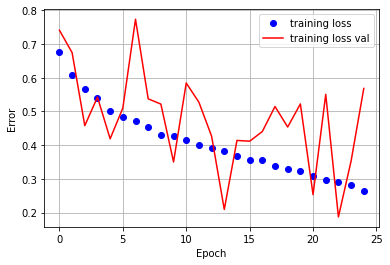

El modelo considera que en la imagen hay un  dog
La imagen contiene de verdad un perro


In [17]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Part 2 - Fitting the CNN to the images

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

history = classifier.fit_generator(training_set,
                                   steps_per_epoch = 250,
                                   epochs = 25,
                                   validation_data = test_set,
                                   validation_steps = 62)

history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss') 
plt.plot(val_loss_values,'r',label='training loss val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()



# Part 3 - Making new predictions
test_image = image.load_img(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\single_prediction\cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
    

print("El modelo considera que en la imagen hay un ", prediction)    
print("La imagen contiene de verdad un perro")    

Una vez ejecutado el modelo podemos observar que no aporta unos resultados nada satisfactorios. Presenta bastante 'overfitting' (tiene una diferencia de casi el 10% entre el 'accuracy' de 'train' y el 'accuracy' de 'test') y tan sólo es capaz de interpretar correctamente el 79% de las imágenes que nunca ha visto, es decir, que no ha entrenado con ellas. 

A pesar de no ejecutar el código inicial sin modificar en este documento, se adjunta una imagen del código ejecutado donde los resultados obtenidos son aun peores porque el modelo presenta un 'overfitting' totalmente desproporcionado:

<img src="image/Output_codigo_profe.jpeg" style="width:550px;height:550px;" align="center"/>



De esta manera, observando tanto el resultado obtenido del código ejecutado como el código inicial, los objetivos para mejorar el modelo propuestos son claros:
* Reducir el overfitting
* Mejorar en la medida de lo posible el rendimiento del modelo

Así pues, a continuación se presentan varias pruebas realizadas que han sido de ayuda para obtener un mejor modelo para el reconocimiento de imágenes que contienen perros y gatos.

# Pruebas realizadas  
Se han realizado diversas pruebas, se pueden encontrar algunas más en la carpeta adjunta de 'pruebas'. De entre todas ellas, las más destacables son las tres presentadas a continuación. Cabe añadir que se verá una mejora en cada una de ellas respecto a la anterior. 

## Prueba 1  
Esta prueba fue una de las primeras en realizar donde se logró algo de mejora. Básicamente, se decidió añadir dos capas intermedias en el nivel de full conection y varios 'Dropouts'. Más contretamente, los cambios realizados fueron:
* Capa 'Fully Connected' intermedia de 64 neuronas con una función de activación de tipo 'relu'
* Capa 'Fully Connected' intermedia de 32 neuronas con una función de activación de tipo 'relu'
* Se hace uso de la función 'Droput' para eliminar el 25% de conexiones entre capas
* Se añade un 'Earlystopper' para evitar que el modelo siga entrenando si no obtiene unos resultados con una diferenica notable
* Se utiliza el 'optimizer' 'RMSprop' en vez del 'adam'

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/20
350/350 [==============================] - 41s 118ms/step - loss: 0.6556 - accuracy: 0.6089 - val_loss: 0.4233 - val_accuracy: 0.7168
Epoch 2/20
350/350 [==============================] - 40s 116ms/step - loss: 0.5835 - accuracy: 0.6981 - val_loss: 0.4600 - val_accuracy: 0.7465
Epoch 3/20
350/350 [==============================] - 37s 105ms/step - loss: 0.5471 - accuracy: 0.7229 - val_loss: 0.5017 - val_accuracy: 0.7618
Epoch 4/20
350/350 [==============================] - 38s 109ms/step - loss: 0.5198 - accuracy: 0.7466 - val_loss: 0.4771 - val_accuracy: 0.7646
Epoch 5/20
350/350 [==============================] - 39s 111ms/step - loss: 0.4894 - accuracy: 0.7645 - val_loss: 0.5133 - val_accuracy: 0.7511
Epoch 6/20
350/350 [==============================] - 37s 107ms/step - loss: 0.4795 - accuracy: 0.7767 - val_loss: 0.4559 - val_accuracy: 0.7726
Epoch 7/20
350/350 [==========================

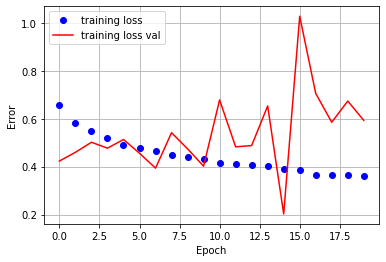

El modelo considera que en la imagen hay un  dog
La imagen contiene de verdad un perro


In [19]:
# Importar las librerías y paquetes

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Parte 1 - Construir el modelo de CNN

# Inicializar la CNN
classifier = Sequential()

# Paso 1 - Convolución
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), 
                      input_shape = (64, 64, 3), activation = "relu"))

# Paso 2 - Max Pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Una segunda capa de convolución y max pooling
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), activation = "relu"))

classifier.add(MaxPooling2D(pool_size = (2,2)))

# Este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
classifier.add(Dropout(0.25)) # NUEVO 

# Paso 3 - Flattening
classifier.add(Flatten())

# Paso 4 - Full Connection

classifier.add(Dense(units = 128, activation = "relu"))
classifier.add(Dense(units = 64, activation = "relu")) #NUEVO
classifier.add(Dense(units = 32, activation = "relu")) #NUEVO

#este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
classifier.add(Dropout(0.25)) # NUEVO 
classifier.add(Dense(units = 1, activation = "sigmoid"))

# Compilar la CNN
classifier.compile(optimizer = "RMSprop", loss = "binary_crossentropy", metrics = ["accuracy"]) #NUEVO
#classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Parte 2 - Ajustar la CNN a las imágenes para entrenar 

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_dataset = train_datagen.flow_from_directory(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\training_set',
                                                    target_size=(64, 64),
                                                    batch_size=32,
                                                    class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\test_set',
                                                target_size=(64, 64),
                                                batch_size=32,
                                                class_mode='binary')

#NUEVO 
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=100, verbose=1, mode='auto')

# Ajusta el modelo 20 iteraciones con el 'earlystopper' y lo asigna al historial
history = classifier.fit_generator(training_dataset,
                        steps_per_epoch=350,
                        epochs=20,
                        validation_data=testing_dataset,
                        validation_steps=200,
                        callbacks = [earlystopper])

# Plots 'history'
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss') 
plt.plot(val_loss_values,'r',label='training loss val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()


# Parte 3 - Cómo hacer nuevas predicciones
test_image = image.load_img(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\single_prediction\cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_dataset.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
    
print("El modelo considera que en la imagen hay un ", prediction)    
print("La imagen contiene de verdad un perro")  

Como se puede observar, los resultados obtenidos son ligeramente mejores a los obtenidos en el código inicial. Gracias a los 'Dropout' se reduce de forma considerable el overfitting del modelo (aunque todavía es notable). Sin embargo, se reduce ligeramente la clasificación del modelo gracias a las capas intermedias añadidas. Además, cabe añadir que el 'Earlystopper' no se activa por la gran diferencia entre los resultados de cada 'epoch'.

## Prueba 2
En esta prueba tan sólo ha habido un cambio respeto a la anterior:
* Se ha eliminado la capa intermedia de 64 neruonas

De esta manera, permanece la capa intermedia de 32 neuronas. 

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/20
350/350 [==============================] - 41s 117ms/step - loss: 0.6560 - accuracy: 0.6156 - val_loss: 0.4244 - val_accuracy: 0.7177
Epoch 2/20
350/350 [==============================] - 40s 114ms/step - loss: 0.5786 - accuracy: 0.6980 - val_loss: 0.3914 - val_accuracy: 0.7631
Epoch 3/20
350/350 [==============================] - 40s 115ms/step - loss: 0.5387 - accuracy: 0.7291 - val_loss: 0.4646 - val_accuracy: 0.7561
Epoch 4/20
350/350 [==============================] - 39s 112ms/step - loss: 0.5156 - accuracy: 0.7475 - val_loss: 0.5463 - val_accuracy: 0.7774
Epoch 5/20
350/350 [==============================] - 39s 111ms/step - loss: 0.4919 - accuracy: 0.7640 - val_loss: 0.5457 - val_accuracy: 0.7393
Epoch 6/20
350/350 [==============================] - 41s 116ms/step - loss: 0.4792 - accuracy: 0.7713 - val_loss: 0.4513 - val_accuracy: 0.7718
Epoch 7/20
350/350 [==========================

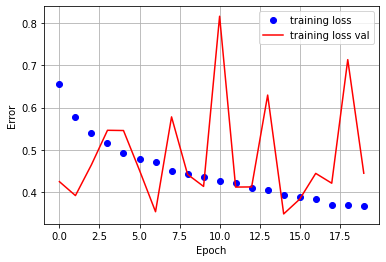

El modelo considera que en la imagen hay un  dog
La imagen contiene de verdad un perro


In [18]:
# Importar las librerías y paquetes

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Parte 1 - Construir el modelo de CNN

# Inicializar la CNN
classifier = Sequential()

# Paso 1 - Convolución
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), 
                      input_shape = (64, 64, 3), activation = "relu"))

# Paso 2 - Max Pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Una segunda capa de convolución y max pooling
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), activation = "relu"))

classifier.add(MaxPooling2D(pool_size = (2,2)))


#este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
classifier.add(Dropout(0.25)) # NUEVO 

# Paso 3 - Flattening
classifier.add(Flatten())

# Paso 4 - Full Connection

classifier.add(Dense(units = 128, activation = "relu"))
#classifier.add(Dense(units = 64, activation = "relu")) #NUEVO
classifier.add(Dense(units = 32, activation = "relu")) #NUEVO

# Este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
classifier.add(Dropout(0.25)) # NUEVO 
classifier.add(Dense(units = 1, activation = "sigmoid"))

# Compilar la CNN
classifier.compile(optimizer = "RMSprop", loss = "binary_crossentropy", metrics = ["accuracy"]) #NUEVO
#classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Parte 2 - Ajustar la CNN a las imágenes para entrenar 

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_dataset = train_datagen.flow_from_directory(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\training_set',
                                                    target_size=(64, 64),
                                                    batch_size=32,
                                                    class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\test_set',
                                                target_size=(64, 64),
                                                batch_size=32,
                                                class_mode='binary')

#NUEVO  
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=100, verbose=1, mode='auto')

# Ajusta el modelo a 20 iteraciones con el 'earlystopper' y lo asigna al historial
history = classifier.fit_generator(training_dataset,
                        steps_per_epoch=350,
                        epochs=20,
                        validation_data=testing_dataset,
                        validation_steps=200,
                        callbacks = [earlystopper])

# Plots 'history'
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss') 
plt.plot(val_loss_values,'r',label='training loss val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()


# Parte 3 - Cómo hacer nuevas predicciones
test_image = image.load_img(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\single_prediction\cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_dataset.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
    
print("El modelo considera que en la imagen hay un ", prediction)    
print("La imagen contiene de verdad un perro")   

Una vez ejecutado el modelo, podemos observar que está vez el modelo si mejora la clasificación de imágenes de testeo y, por ende, se reduce el 'overfitting' del modelo. Además, gracias al plot obtenido podemos observar que, a pesar de los sobresaltos del error en el testeo, éste parece que se va reduciendo a medida que augmentan las épocas. 

## Prueba 3  
Esta prueba respeto a la anterior presenta dos cambios muy significativos:
* Se decide doblar el numero de numero de neuronas de convolución y de polling. De dos niveles de CONV-POOL pasamos a tener 4 niveles
* Gracias al plot anterior, se decide aumentar considerablemente el número de épocas. De 20 épocas a 60

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/60
350/350 [==============================] - 73s 209ms/step - loss: 0.6889 - accuracy: 0.5408 - val_loss: 0.6446 - val_accuracy: 0.6064
Epoch 2/60
350/350 [==============================] - 34s 98ms/step - loss: 0.6552 - accuracy: 0.6143 - val_loss: 0.6683 - val_accuracy: 0.6126
Epoch 3/60
350/350 [==============================] - 35s 99ms/step - loss: 0.6154 - accuracy: 0.6645 - val_loss: 0.6195 - val_accuracy: 0.6023
Epoch 4/60
350/350 [==============================] - 34s 98ms/step - loss: 0.5867 - accuracy: 0.6941 - val_loss: 0.6214 - val_accuracy: 0.7294
Epoch 5/60
350/350 [==============================] - 34s 98ms/step - loss: 0.5581 - accuracy: 0.7140 - val_loss: 0.5016 - val_accuracy: 0.7042
Epoch 6/60
350/350 [==============================] - 35s 99ms/step - loss: 0.5391 - accuracy: 0.7337 - val_loss: 0.4755 - val_accuracy: 0.7663
Epoch 7/60
350/350 [==============================]

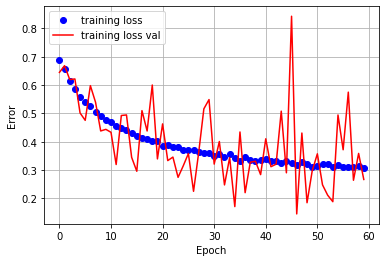

El modelo considera que en la imagen hay un  dog
La imagen contiene de verdad un perro


In [3]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


# Parte 1 - Construir el modelo de CNN

# Inicializar la CNN
classifier = Sequential()

# Paso 1 - Convolución
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), 
                      input_shape = (64, 64, 3), activation = "relu"))

# Paso 2 - Max Pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Una segunda capa de convolución y max pooling
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), activation = "relu"))

classifier.add(MaxPooling2D(pool_size = (2,2)))


#este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
classifier.add(Dropout(0.25 )) # NUEVO 

# Paso 3 - Flattening
#classifier.add(Flatten())

#################################################################

classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), 
                      input_shape = (64, 64, 3), activation = "relu"))

# Paso 2 - Max Pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Una segunda capa de convolución y max pooling
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), activation = "relu"))

classifier.add(MaxPooling2D(pool_size = (2,2)))


# Este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
classifier.add(Dropout(0.25 )) # NUEVO 

# Paso 3 - Flattening
classifier.add(Flatten())
################################################################################

# Paso 4 - Full Connection

classifier.add(Dense(units = 128, activation = "relu"))
#classifier.add(Dense(units = 64, activation = "relu")) #NUEVO
classifier.add(Dense(units = 32, activation = "relu")) #NUEVO
#este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
classifier.add(Dropout(0.25)) # NUEVO 
classifier.add(Dense(units = 1, activation = "sigmoid"))

# Compilar la CNN
classifier.compile(optimizer = "RMSprop", loss = "binary_crossentropy", metrics = ["accuracy"]) #NUEVO
#classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Parte 2 - Ajustar la CNN a las imágenes para entrenar 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_dataset = train_datagen.flow_from_directory(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\training_set',
                                                    target_size=(64, 64),
                                                    batch_size=32,
                                                    class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\test_set',
                                                target_size=(64, 64),
                                                batch_size=32,
                                                class_mode='binary')

#NUEVO 
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=100, verbose=1, mode='auto')

# Ajusta el modelo a 60 iteraciones con el 'earlystopper' y lo asigna al historial
history = classifier.fit_generator(training_dataset,
                        steps_per_epoch=350,
                        epochs=60,
                        validation_data=testing_dataset,
                        validation_steps=200,
                        callbacks = [earlystopper])

# Plots 'history'
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss') 
plt.plot(val_loss_values,'r',label='training loss val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()


# Parte 3 - Cómo hacer nuevas predicciones
test_image = image.load_img(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\single_prediction\cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_dataset.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
    
print("El modelo considera que en la imagen hay un ", prediction)    
print("La imagen contiene de verdad un perro")       

Una vez ejecutado el nuevo modelo, observamos que los resultados obtenidos són mucho mejores. Se ha reducido por completo el 'overfitting' y se ha mejorado considerablemente la clasificación. En este punto, el modelo es capaz de clasificar correctamente el 88,40% de las imágenes. Sin embargo, observando el plot de la evolución de los errores parece que es posible mejorar aún más el modelo. Con esto en mente se llega a la implementación de la CNN final.

# CNN final

Después de las diversas pruebas realizadas se ha logrado obtener un mejor modelo para la clasificación de imágenes de perros y gatos. Como se ha mencionado anteriormente, con las pruebas realizadas se ha logrado obtener un modelo con neuronas convolucionales que ya no presentase 'overfitting'. De esta manera, el objetivo principal ha sido mejorar el modelo. 

En las siguientes celdas se describirá el mejor modelo que se ha obtenido teniendo en cuenta la 'accuracy' obtenida y la evolución del error del modelo en cada época. Además, como se podrá observar en la siguientes celdas, se describirá de manera más detallada los cambios realizados respecto al código inicial presentado en el curso Udemy, cambios que han sido mencionados en las pruebas anteriores. 

## Implementación de las capas convolucionales

In [5]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Inicializar la CNN
classifier = Sequential()

# Paso 1 - Convolución
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), 
                      input_shape = (64, 64, 3), activation = "relu"))

# Paso 2 - Max Pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Una segunda capa de convolución y max pooling
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), activation = "relu"))

classifier.add(MaxPooling2D(pool_size = (2,2)))


#este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
classifier.add(Dropout(0.25 )) # NUEVO 

#################### Duplicación de las capas convolucionales ####################

# Paso 1 - Convolución
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), 
                      input_shape = (64, 64, 3), activation = "relu"))

# Paso 2 - Max Pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Una segunda capa de convolución y max pooling
classifier.add(Conv2D(filters = 32,kernel_size = (3, 3), activation = "relu"))

classifier.add(MaxPooling2D(pool_size = (2,2)))

##################################################################################

#este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
classifier.add(Dropout(0.25 )) # NUEVO 

# Paso 3 - Flattening
classifier.add(Flatten())


Esta parte del código es donde se encuentran la mayoría de los cambios, ya que en esta celda se lleva a cabo la implementación de las capas convolucionales del modelo. Como se ha descrito anteriormente, toda red con neuronas convolucionales presentan una estructura inicial muy parecida, la cual podemos identificar con los comentarios 'Paso 1', 'Paso 2' y 'Paso 3'. De esta manera, los cambios realizados son:

* Para reducir el overfitting se ha usado la función 'Dropout', que elimina el % de conexiones entre capas. En nuestro caso, se eliminan el 25% de conexiones entre varias capas convolucionales.
* Para mejorar el modelo, se ha decidido añadir más capas convolucionales, es decir, se han añadido nuevas capas de convolución y de polling (siguiendo el consejo realizado por el doctor ***Andrew Ng***). En nuestro caso, se ha decidido doblar el número de capas del código inicial (4 capas convolucionales y 4 capas de polling).  

## Full connection

In [6]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Paso 4 - Full Connection

classifier.add(Dense(units = 128, activation = "relu"))
#classifier.add(Dense(units = 64, activation = "relu")) #NUEVO
classifier.add(Dense(units = 32, activation = "relu")) #NUEVO

#este dropout desactiva el 25% de las conexiones entre las neuronas, lo cual mejora los resultados
classifier.add(Dropout(0.25)) # NUEVO 

classifier.add(Dense(units = 1, activation = "sigmoid"))

Una vez establecidas las capas convolucionales del modelo, se lleva a cabo el 'Paso 4' llamado 'Full Connection'. En este momento, se implementan las capas encargadas de interpretar las características de las imágenes para así poder clasificarlas. Para ello se implementan capas de neuronas comunes que son alimentadas por los datos de las neuronas convolucionales.

En un inicio, el código inicial tan sólo presentaba dos capas. Una capa de 128 neuronas y una capa de salida de 1 neurona. Gracias a las pruebas realizadas (como la linia comentada de 64 neuronas), se ha comprobado que es necesario añadir más capas intermedias para que el modelo pueda mejorar la clasificación. Despues de varias pruebas, la mejor combinación de capas es la siguiente:

* Una primera capa de 128 neuronas con una función de activación tipo 'relu'
* Una segunda capa de 32 neuronas con una función de activación tipo 'relu'
* Una capa de salida de 1 neurona con una función de activación tipo 'sigmoid'. La función de activación sigmoid es ideal para casos binarios, es decir, perro o gato.

Además, es necesario mencionar que se ha usado una vez más la función 'Dropout' de un 25% entre las dos últimas capas para reducir aún más el overfitting que puede sufrir el modelo.


## Compilar CNN

In [7]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Compilar la CNN
classifier.compile(optimizer = "RMSprop", loss = "binary_crossentropy", metrics = ["accuracy"]) #NUEVO
#classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

Una vez implementado la arquitectura de la red neuronal de nuestro modelo, llega el momento de compilar la red. Para ello se ha decido usar un 'optimizer' distinto. En el código inicial, se recurre al optimizador 'adam' (el más habitual en las redes neuronales). Sin embargo, después de una búsqueda se ha decidido usar el optimizer 'RMSprop' obteniendo mejores resultados. Es necesario mencionar que durante la búsqueda de alternativas para la mejora del código se observó el uso del optimizer 'RMSprop' para la identificación de imágenes que representaban dígitos. Esta mejora se debe a que RMSprop es un algoritmo de optimización que aplica el descenso de gradiente disminuyendo radicalmente el "learning rate" en el proceso. En el caso de del "adam", según nuestras pruebas, este proceso requiere de más épocas para conseguir la convergencia, lo que introduce "overfitting". Con un "learning rate" que decae más rápidamente es más fácil conseguir que el error cometido disminuya hasta oscilar muy poco sin que se haya introducido "overfitting".

## Ajuste de la CNN para el entrenamiento

In [8]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Parte 2 - Ajustar la CNN a las imágenes para entrenar 

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_dataset = train_datagen.flow_from_directory(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\training_set',
                                                    target_size=(64, 64),
                                                    batch_size=32,
                                                    class_mode='binary')

testing_dataset = test_datagen.flow_from_directory(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\test_set',
                                                target_size=(64, 64),
                                                batch_size=32,
                                                class_mode='binary')

#NUEVO 
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=100, verbose=1, mode='auto')

# Ajusta el modelo a más de 1000 iteraciones con el 'earlystopper' y lo asigna al historial
history = classifier.fit_generator(training_dataset,
                        steps_per_epoch=350, #NUEVO
                        epochs=150, #NUEVO
                        validation_data=testing_dataset,
                        validation_steps=200,
                        callbacks = [earlystopper])


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/150
350/350 [==============================] - 36s 103ms/step - loss: 0.6908 - accuracy: 0.5290 - val_loss: 0.7028 - val_accuracy: 0.5874
Epoch 2/150
350/350 [==============================] - 35s 99ms/step - loss: 0.6475 - accuracy: 0.6288 - val_loss: 0.6967 - val_accuracy: 0.6844
Epoch 3/150
350/350 [==============================] - 34s 98ms/step - loss: 0.6029 - accuracy: 0.6745 - val_loss: 0.5479 - val_accuracy: 0.7117
Epoch 4/150
350/350 [==============================] - 34s 98ms/step - loss: 0.5758 - accuracy: 0.7055 - val_loss: 0.5460 - val_accuracy: 0.7431
Epoch 5/150
350/350 [==============================] - 35s 99ms/step - loss: 0.5557 - accuracy: 0.7169 - val_loss: 0.4563 - val_accuracy: 0.7300
Epoch 6/150
350/350 [==============================] - 34s 98ms/step - loss: 0.5216 - accuracy: 0.7436 - val_loss: 0.6727 - val_accuracy: 0.7404
Epoch 7/150
350/350 [========================

En esta celda se lleva a cabo el ajuste de la red para su entrenamiento, es decir, se inicia el entrenamiento del modelo a través de un conjunto de imágenes de perros y gatos. Para el entrenamiento se han usado un total de 8000 imágenes de perros y gatos y un total de 2000 imágenes per el testeo del modelo. Así pues, el proceso de aprendizaje del modelo tiene en cuenta un total de 10000 imágenes, hecho que conlleva un mayor tiempo de computación. 

Con el código inicial el tiempo de computación era excesivamente alto, sin exagerar el modelo entrenaba durante horas. Para reducir este tiempo se han realizado dos cambios muy significativos:
* Se han reducido los pasos por cada época. En un inicio eran 8000 pasos por época y ahora tan sólo 350, es decir, ahora mismo el modelo entrena con 350 'batches' de imágenes por cada 'epoch'. Como cada 'batch' es de 32 imágenes el modelo entrena con 11200 imágenes en cada 'epoch'. Antes, con los 8000 pasos por época, se entrenaba con 256000 imágenes en cada 'epoch' cosa que hacía que el tiempo de computo se disparase y que el modelo sobre-entrenase.
* Se ha añadido un 'Earlystopper' al modelo. Básicamennte, es una función de Keras que obliga al modelo a dejar de entrenar si la métrica elegida no mejora significamente. En nuestro caso, se ha decido que el modelo deje de entrenar si la diferencia entre los errores es de 0.01. En otros modelos vistos durante la búsqueda, esta diferencia era aún menor. 

Gracias a la visualización de la evolución del error del entrenamiento y testeo durante las pruebas se ha decidido aumentar el número de épocas a 150. En comparación a las pruebas realizadas, es un aumento considerable. Sin embargo, gracias al 'Earlystopper' definido, si el modelo no necesita tantas épocas para su entrenamiento el modelo se detendrá.

De esta manera, una vez ejecutada esta celda podemos observar la accuracy que presenta el modelo. Se ha logrado una ligera mejora respeto a las pruebas anteriores. El modelo es capaz de clasificar correctamente el 88,92% de las imagenes. Un resultado satisfactorio. Además, cabe destacar la activación del 'Earlystopper' en la época 147.


## Plot de la evolución de la pérdida

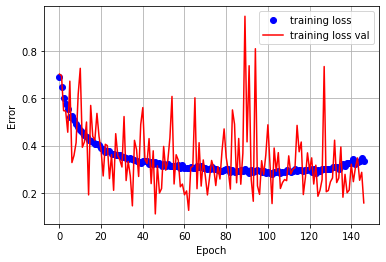

In [9]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Plots 'history'
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss') 
plt.plot(val_loss_values,'r',label='training loss val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()


Toda esta celda es un añadido al codigo inicial. Se ha decidido que sería de gran ayuda poder observar la evolución del error durante el aprendizaje y así poder observar si el modelo llega a estabilizarse. De esta manera, el plot obtenido ha sido de gran ayuda para la decisión del aumento de épocas durante el entrenamiento, como se ha mencionado anteriormente. 

Como se puede observar en el plot obtenido, a medida que avanza el modelo, que aumentan las épocas, el modelo logra establecerse. 

## Comprobación de la funcionalidad de la CNN

Por último, en la siguiente celda no hay cambios a destacar. Tan sólo se han añadido dos 'prints' para observar si el modelo identifica de forma positiva una imagen. En esta caso, se ha decidido cargar la imagen de un perro. 

In [10]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Parte 3 - Cómo hacer nuevas predicciones
test_image = image.load_img(r'C:\Users\munta\OneDrive\Escritorio\Aprendizaje Profundo\G03_Project2B\G03_Project2B\deeplearning-az-master\datasets\Part 2 - Convolutional Neural Networks (CNN)\dataset\single_prediction\cat_or_dog_1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_dataset.class_indices
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'

#NUEVO    
print("El modelo considera que en la imagen hay un ", prediction)    
print("La imagen contiene de verdad un perro")       

El modelo considera que en la imagen hay un  dog
La imagen contiene de verdad un perro


Como se puede observar, el modelo logra identificar de forma correcta la imagen. 

# Conclusiones y trabajo futuro

Para finalizar, con este tabajo podemos concluir que el objetivo principal de la práctica (aumentar el 'accuracy' del modelo mientras se evita que sobre-entrene) ha sido alcanzado satisfactoriamente. Hemos partido de un modelo con un 'accuracy' en las imágenes de testeo del 80-79% y con un 'overfitting' considerable y hemos llegado a tener un 'accuracy' de casi el 89% y un 'overfitting' nulo.

Como trabajo futuro queda probar nuestro modelo con un dataset nuevo y verificar que funciona y seguir testeando nuevas arquitecturas para intentar aumentar aún más el 'accuracy'.